In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!pip install transformers tokenizers
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

In [ ]:
#package imports 

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import pytorch_lightning as pl

from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

from typing import List
import logging
import copy
import os
import sys
import gc
import random
from functools import lru_cache
from argparse import Namespace
from packaging import version
from tqdm.autonotebook import tqdm

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:

_CITATION = '''
@inproceedings{rashkin2019towards,
  title = {Towards Empathetic Open-domain Conversation Models: a New Benchmark and Dataset},
  author = {Hannah Rashkin and Eric Michael Smith and Margaret Li and Y-Lan Boureau},
  booktitle = {ACL},
  year = {2019},
}
'''

In [ ]:
train_path = "drive/MyDrive/Individual Project/Data/Emotion/my_emp_dia_train_equal.txt"
test_path = "drive/MyDrive/Individual Project/Data/Emotion/my_emp_dia_test_equal.txt"
val_path = "drive/MyDrive/Individual Project/Data/Emotion/my_emp_dia_val_equal.txt"

In [ ]:
labels = [ "sadness", "joy", "anger", "fear", "love", "instability", "disgust", "disappointment", "shame", "guilt", "envy"]
label2int = dict(zip(labels, list(range(len(labels)))))

In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(21)

###Now we can start building a classifier

In [ ]:
#load tokenizer
tokenizer = AutoTokenizer.from_pretrained('roberta-large')

!mkdir -p tokenizer

tokenizer.save_pretrained("tokenizer")

!ls tokenizer

In [ ]:
#load actual model
model = AutoModelWithLMHead.from_pretrained('roberta-large')

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:973: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [ ]:
class EmoClassificationModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=1024, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            nn.Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )
        
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)
        
        return self.classifier(hidden_states[0][:, 0, :])

Now some dataset preparation for the fine-tuning process.

In [ ]:
!mkdir -p tokenizer

In [ ]:
#load pretrained tokenizer information
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [ ]:
!ls tokenizer

merges.txt		 tokenizer_config.json	vocab.json
special_tokens_map.json  tokenizer.json


In [ ]:
#implementation of CollateFN to do tokenization and batches of sequences

class TokenizersCollateFn:
    def __init__(self, max_tokens=128): 

        #RoBERTa uses the BPE tokenizer, similarly to GPT-2
        t = ByteLevelBPETokenizer(
            "tokenizer/vocab.json",
            "tokenizer/merges.txt"
        )
        t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding(pad_id=t.token_to_id("<pad>"))
        self.tokenizer = t

    def __call__(self, batch):
        encoded = self.tokenizer.encode_batch([x[0] for x in batch])
        sequences_padded = torch.tensor([enc.ids for enc in encoded])
        attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
        labels = torch.tensor([x[1] for x in batch])
        
        return (sequences_padded, attention_masks_padded), labels

In [ ]:
#class to create dataset objects from the data

class EmoDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.data_column = "text"
        self.class_column = "class"
        self.data = pd.read_csv(path, sep=";", header=None, names=[self.data_column, self.class_column],
                               engine="python")

    def __getitem__(self, idx):
        return self.data.loc[idx, self.data_column], label2int[self.data.loc[idx, self.class_column]]

    def __len__(self):
        return self.data.shape[0]

In [ ]:
class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = EmoClassificationModel(AutoModelWithLMHead.from_pretrained("roberta-large").base_model, len(labels))
        self.save_hyperparameters(hparams)

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    num_workers = 4,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr) #we use AdamW as this usually performs well
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]
   
    def save_model(self):
        torch.save(self.model.state_dict(), '/content/RoBERTa_large_finetuned_emp_dia.pt')

In [ ]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=10,
    lr=5E-05,
    accumulate_grad_batches=2,
    seed=21
)
module = TrainingModule(hparams)

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:973: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [ ]:
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

####Now we can fine-tune

In [ ]:
#train (using cuda)
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs,
                     accumulate_grad_batches=hparams.accumulate_grad_batches)

trainer.fit(module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:440: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name  | Type                   | Params
-------------------------------------------------
0 | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
module.save_model()

##Evaluation on the held-out test

In [ ]:
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval().cuda()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        batch = (X.cuda(), attn.cuda())
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(batch), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=4))


________________________________________________________________________________
                precision    recall  f1-score   support

       sadness     0.6316    0.7273    0.6761        66
           joy     0.9000    0.8182    0.8571        66
         anger     0.6897    0.6061    0.6452        66
          fear     0.7564    0.8939    0.8194        66
          love     0.8594    0.8333    0.8462        66
   instability     0.8308    0.8182    0.8244        66
       disgust     0.8028    0.8636    0.8321        66
disappointment     0.6667    0.6970    0.6815        66
         shame     0.6970    0.6970    0.6970        66
         guilt     0.7969    0.7727    0.7846        66
          envy     0.9091    0.7576    0.8264        66

      accuracy                         0.7713       726
     macro avg     0.7764    0.7713    0.7718       726
  weighted avg     0.7764    0.7713    0.7718       726



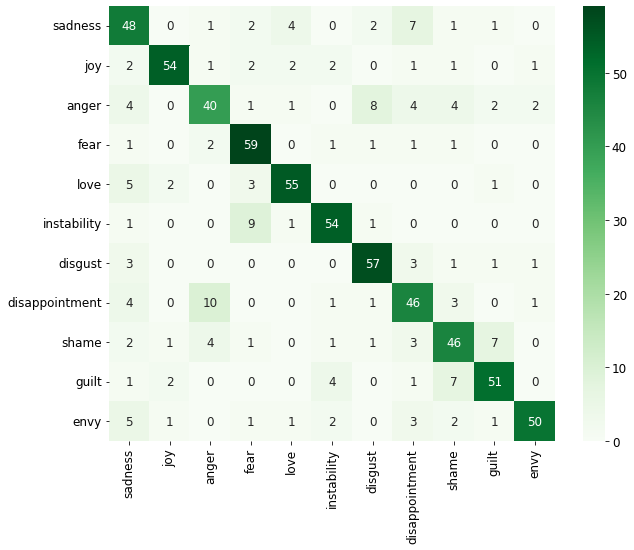

In [ ]:
#plot confusion matrix

cm = confusion_matrix(true_y, pred_y, labels=range(len(labels)))
df_cm = pd.DataFrame(cm, index = labels, columns = labels)

plt.rcParams.update({'font.size': 12}) 
plt.figure(figsize = (10,8));
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g');

## Fine tune on our data

In [ ]:
#we define the paths for train, val, test
train_path = "drive/MyDrive/Individual Project/Data/Emotion/bt_train_equal_no_jealous.txt"
test_path = "drive/MyDrive/Individual Project/Data/Emotion/bt_test_equal_no_jealous.txt"
val_path = "drive/MyDrive/Individual Project/Data/Emotion/bt_val_equal_no_jealous.txt"

In [ ]:

class TrainingModule(pl.LightningModule):
    def __init__(self, hparams, model):
        super().__init__()
        self.model = model
        self.loss = nn.CrossEntropyLoss()
        self.save_hyperparameters(hparams)

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    num_workers = 4,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr) #we use AdamW 
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

    def save_model(self):
        torch.save(self.model.state_dict(), '/content/RoBERTa__large_double_finetuned_emp_dia.pt')

In [ ]:
model = EmoClassificationModel(AutoModelWithLMHead.from_pretrained("roberta-large").base_model, len(labels))
device = torch.device('cuda:0')
model.load_state_dict(torch.load('/content/RoBERTa_large_finetuned_emp_dia.pt'))
model.to(device)

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:973: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


EmoClassificationModel(
  (base_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (L

In [ ]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=10,
    lr=5E-05,
    accumulate_grad_batches=2,
    seed=21
)
module = TrainingModule(hparams, model)

In [ ]:
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#train
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs,
                     accumulate_grad_batches=hparams.accumulate_grad_batches)

trainer.fit(module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:440: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | EmoClassificationModel | 355 M 
1 | los

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
module.save_model()

##Evaluation on the held-out test

In [ ]:
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval().cuda()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        batch = (X.cuda(), attn.cuda())
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(batch), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=4))

In [ ]:
#plot confusion matrix

cm = confusion_matrix(true_y, pred_y, labels=range(len(labels)))
df_cm = pd.DataFrame(cm, index = labels, columns = labels)

plt.rcParams.update({'font.size': 12}) 
plt.figure(figsize = (10,8));
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g');